In [1175]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io

# Will allow us to embed images in the notebook
%matplotlib inline

Набор данных ex2data1.txt представляет собой текстовый файл, содержащий информацию об оценке студента по первому экзамену (первое число в строке), оценке по второму экзамену (второе число в строке) и поступлении в университет (0 - не поступил, 1 - поступил).


**1. Загрузите данные ex2data1.txt из текстового файла.**

In [504]:
df1 = pandas.read_csv('ex2data1.txt', header=None, names=['exam_1', 'exam_2', 'result'])

In [505]:
df1.head()

,exam_1,exam_2,result
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


**2. Постройте график, где по осям откладываются оценки по предметам, а точки обозначаются двумя разными маркерами в зависимости от того, поступил ли данный студент в университет или нет.**


In [506]:
def create_normalizer(df):
    mean = df.mean().values
    rng = (df.max()-df.min()).values
    
    def norm_func(val):
        return (val - mean) / rng
    
    def denorm_func(val):
        return val * rng + mean
    
    return norm_func, denorm_func

In [507]:
tmp_df = df1.copy()
tmp_df.insert(0, '', 1)

orig_X = tmp_df.drop('result', axis=1).values
print(f'orig_X.shape = {orig_X.shape}')


norm_func, denorm_func = create_normalizer(df1.copy().drop('result', axis=1))

norm_df = norm_func(df1.copy().drop('result', axis=1)) 
norm_df.insert(0, '', 1)

norm_X = norm_df.values
print(f'norm_X.shape = {norm_X.shape}')

Y = tmp_df['result'].values.reshape(-1, 1)
print(f'Y.shape = {Y.shape}')

orig_X.shape = (100, 3)
norm_X.shape = (100, 3)
Y.shape = (100, 1)


In [508]:
r_pass = Y == 1
r_fail = Y == 0

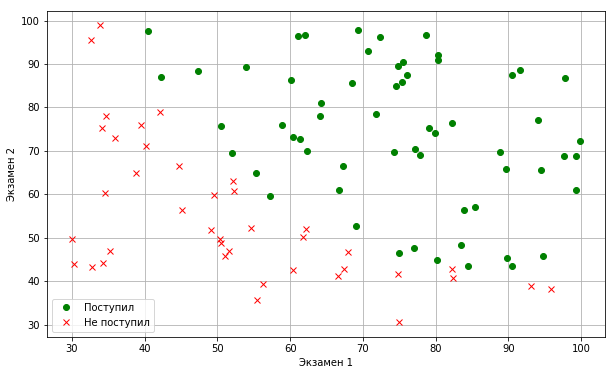

In [509]:
plt.figure(figsize=(10,6))
plt.plot(df1[r_pass]['exam_1'],df1[r_pass]['exam_2'], 'go', label='Поступил')
plt.plot(df1[r_fail]['exam_1'],df1[r_fail]['exam_2'], 'rx', label='Не поступил')
plt.xlabel('Экзамен 1')
plt.ylabel('Экзамен 2')
plt.legend(loc=3)
plt.grid(True)

**3. Реализуйте функции потерь J(θ) и градиентного спуска для логистической регрессии с использованием векторизации.**

In [510]:
#theta = np.ones([3, 1])
#print(f'theta.shape = {theta.shape}')

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def h(theta, X):
    return sigmoid(np.dot(X, theta))

In [571]:
def J(theta, X, Y):
    m = len(X)
    
    h_res = h(theta, X)
    
    e1 = np.dot(-Y.T, np.log(h_res))
    e2 = np.dot((1 - Y).T, np.log(1 - h_res))
    
    return (1 / m) * (e1 - e2).item()

initial_theta = np.zeros((orig_X.shape[1],1))
J(initial_theta, orig_X, Y)

0.6931471805599452

In [512]:
def gd(X, Y, iterations = 200, alpha = 0.01):
    n = X.shape[1]
    m = len(Y)
    
    theta = np.zeros([n, 1])    

    j_hist = []
    
    for i in range(iterations):
        h_res = h(theta, X)
        
        dt = np.dot(X.T, (h_res - Y))
        
        theta = theta - (alpha / m) * dt
        
        j_hist.append(J(theta, X, Y))
    
    return theta, np.asarray(j_hist)

In [513]:
gd_theta, j_hist = gd(norm_X, Y, 20000, 0.5)

print(f'\u03B8 = {gd_theta.reshape(-1)}')
print(f'J(\u03B8) = {j_hist[-1]}')

θ = [ 1.71388635 14.35013779 13.71561879]
J(θ) = 0.2034984061429642


Text(0, 0.5, 'J(θ)')

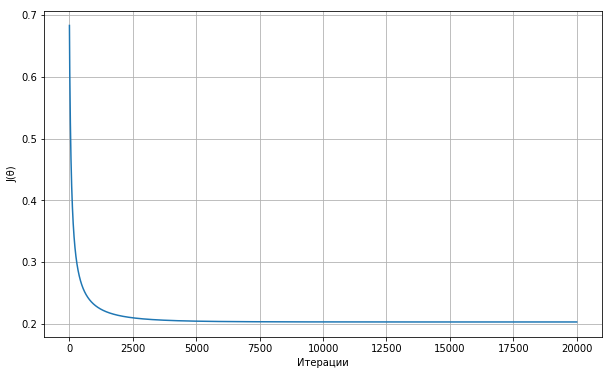

In [514]:
plt.figure(figsize=(10,6))
plt.plot(range(len(j_hist)), j_hist)
plt.grid(True)
plt.xlabel("Итерации")
plt.ylabel("J(\u03B8)")

**4. Реализуйте другие методы (как минимум 2) оптимизации для реализованной функции стоимости (например, Метод Нелдера — Мида, Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно, генетические методы и т.п.). Разрешается использовать библиотечные реализации методов оптимизации (например, из библиотеки scipy).**

In [515]:
def nelder_mead(X, Y):
    result = optimize.minimize(J, x0=np.zeros([X.shape[1], 1]), args=(X, Y), method='Nelder-Mead')
    return result.x, result.fun

In [516]:
%%time
nm_theta, nm_cost = nelder_mead(norm_X, Y)

print(f'\u03B8 = {nm_theta}')
print(f'J(\u03B8) = {nm_cost}')

θ = [ 1.71844706 14.3885508  13.75365682]
J(θ) = 0.20349770159025407
CPU times: user 25.2 ms, sys: 5.43 ms, total: 30.6 ms
Wall time: 29.4 ms


In [517]:
def bfgs(X, Y):
    result = optimize.minimize(J, x0=np.zeros([X.shape[1], 1]), args=(X, Y), method='BFGS')
    return result.x, result.fun

In [518]:
%%time
bfg_theta, bfg_cost = bfgs(norm_X, Y)

print(f'\u03B8 = {bfg_theta}')
print(f'J(\u03B8) = {bfg_cost}')

θ = [ 1.71892074 14.39127926 13.75789856]
J(θ) = 0.20349771157310137
CPU times: user 9.62 ms, sys: 2.46 ms, total: 12.1 ms
Wall time: 11.3 ms


In [519]:
def bfgs_cust(X, Y):
    
    def jac_cust(theta, X, Y):
        m = len(Y)
        h_res = h(theta, X)
        dt = np.dot((h_res - Y).T, X)
        res = ((1 / m) * dt)
        return res
    
    init_theta = np.zeros([X.shape[1], 1]).flatten()
    
    result = optimize.minimize(J, x0=init_theta, args=(X, Y.flatten()), method='BFGS', jac=jac_cust)
    return result.x, result.fun

In [520]:
%%time
bfg_c_theta, bfg_c_cost = bfgs_cust(norm_X, Y)

print(f'\u03B8 = {bfg_c_theta}')
print(f'J(\u03B8) = {bfg_c_cost}')

θ = [ 1.71892074 14.39127926 13.75789847]
J(θ) = 0.2034977115724625
CPU times: user 7.11 ms, sys: 1.7 ms, total: 8.81 ms
Wall time: 7.83 ms


**5. Реализуйте функцию предсказания вероятности поступления студента в зависимости от значений оценок по экзаменам.**

In [521]:
def predict(theta, x):
    new_x = np.insert(norm_func(x), 0, 1, axis=0).reshape(1, -1)
    return (h(theta, new_x) >= 0.5).astype(int)  

predict(gd_theta, [70, 55]).item()

1

**6. Постройте разделяющую прямую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 2.**

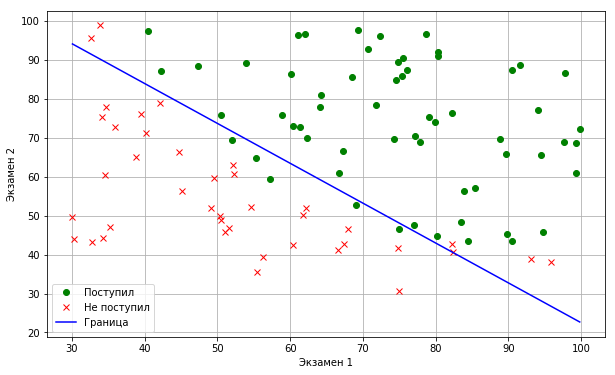

In [522]:
boundary_x = np.array([np.min(norm_X[:,1]), np.max(norm_X[:,1])])
boundary_y = (-1./gd_theta[2])*(gd_theta[0] + gd_theta[1]*boundary_x)


line =  np.hstack((boundary_x.reshape(-1, 1), boundary_y.reshape(-1, 1)))
line = denorm_func(line)


plt.figure(figsize=(10,6))
plt.plot(df1[r_pass]['exam_1'], df1[r_pass]['exam_2'], 'go', label='Поступил')
plt.plot(df1[r_fail]['exam_1'], df1[r_fail]['exam_2'], 'rx', label='Не поступил')
plt.plot(line[:,0], line[:,1],'b-',label='Граница')
plt.xlabel('Экзамен 1')
plt.ylabel('Экзамен 2')
plt.legend(loc=3)
plt.grid(True)

**7. Загрузите данные ex2data2.txt из текстового файла.**

Набор данных ex2data2.txt представляет собой текстовый файл, содержащий информацию о результате первого теста (первое число в строке) и результате второго теста (второе число в строке) изделий и результате прохождения контроля (0 - контроль не пройден, 1 - контроль пройден).

In [496]:
ex2_df = pandas.read_csv('ex2data2.txt', header=None, names=['test_1', 'test_2', 'result'])
ex2_df.head()

,test_1,test_2,result
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [526]:
tmp_ex2_df = ex2_df.copy()

X2 = tmp_ex2_df.drop('result', axis=1).values
print(f'X2.shape = {X2.shape}')

Y2 = tmp_ex2_df['result'].values.reshape(-1, 1)
print(f'Y2.shape = {Y2.shape}')

r2_pass = Y2 == 1
r2_fail = Y2 == 0

X2.shape = (118, 2)
Y2.shape = (118, 1)


**8. Постройте график, где по осям откладываются результаты тестов, а точки обозначаются двумя разными маркерами в зависимости от того, прошло ли изделие контроль или нет.**

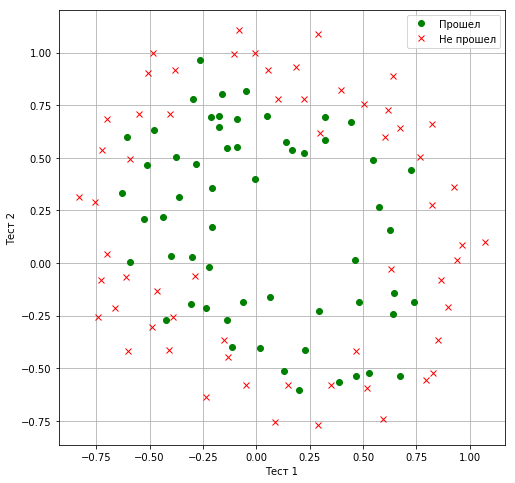

In [835]:
def draw_ex_2_data():
    plt.figure(figsize=(8,8))

    plt.plot(ex2_df[r2_pass]['test_1'], ex2_df[r2_pass]['test_2'], 'go', label='Прошел')
    plt.plot(ex2_df[r2_fail]['test_1'], ex2_df[r2_fail]['test_2'], 'rx', label='Не прошел')
    plt.xlabel('Тест 1')
    plt.ylabel('Тест 2')
    plt.legend()
    plt.grid(True)
draw_ex_2_data()

**9. Постройте все возможные комбинации признаков x1 (результат первого теста) и x2 (результат второго теста), в которых степень полинома не превышает 6, т.е. 1, x1, x2, x12, x1x2, x22, …, x1x25, x26 (всего 28 комбинаций).**

In [565]:
def gen_polynom_matrix(X, degrees):
    # первый столбик с единицами
    m = len(X)
    result = np.ones([m, 1])
    
    for i in range(1, degrees+1):
        for j in range(0, i+1):
            x1 = X[:,0] ** (i-j)
            x2 = X[:,1] ** (j)
            new_column = (x1 * x2).reshape(m, 1) 
            result = np.hstack((result, new_column ))
            
    return result

In [568]:
X2_new = gen_polynom_matrix(X2, 6)
X2_new.shape

(118, 28)

**10. Реализуйте L2-регуляризацию для логистической регрессии и обучите ее на расширенном наборе признаков методом градиентного спуска.**

In [716]:
def J_reg(theta, X, Y, l=0):
    m = len(X)
    
    h_res = h(theta, X)
    
    e1 = np.dot(-Y.T, np.log(h_res))
    e2 = np.dot((1 - Y).T, np.log(1 - h_res))
    
    reg = l/2 * np.sum(np.dot(theta[1:].T, theta[1:]))

    return (1 / m) * ((e1 - e2) + reg).item()

J_reg(np.asarray([0, 0.5, 3]), norm_X, Y, 0.1)

0.5352490576024491

In [1401]:
def gd_step(theta, X, Y, lam=0):
    m = len(Y)
    h_res = h(theta, X)
    
    res = (1./m) * np.dot(X.T, (h_res - Y))

    res[1:] = res[1:] + (lam / m) * theta[1:]
    
    return res

gd_step(np.zeros([X2.shape[1], 1]), X2, Y2)

array([[1.87880932e-02],
       [7.77711864e-05]])

In [1402]:
def gd_reg(X, Y, iterations = 200, alpha = 0.01, l=0):
    n = X.shape[1]
    m = len(Y)
    
    theta = np.zeros([n, 1])    

    j_hist = []
    
    for i in range(iterations):         
        theta = theta - alpha * gd_step(theta, X, Y, l)
        j_hist.append(J_reg(theta, X, Y, l))
    
    return theta, np.asarray(j_hist)

In [1403]:
gd_reg_theta, j_reg_hist = gd_reg(X2, Y2, 10000)

print(f'\u03B8 = {gd_reg_theta.reshape(-1)}')
print(f'J(\u03B8) = {j_reg_hist[-1]}')

θ = [-0.30674593 -0.02682097]
J(θ) = 0.6902628739903154


In [1404]:
gd_reg_theta_new, j_reg_hist_new = gd_reg(X2_new, Y2, 100)

print(f'\u03B8 = {gd_reg_theta_new.reshape(-1)}')
print(f'J(\u03B8) = {j_reg_hist_new[-1]}')

θ = [-0.00166241 -0.01681749  0.00281924 -0.04800576 -0.01140428 -0.03447094
 -0.01695299 -0.00686679 -0.0078626  -0.02109818 -0.03785319 -0.00213995
 -0.01231582 -0.00306428 -0.03684644 -0.01883949 -0.00413983 -0.00320314
 -0.00555821 -0.00436659 -0.02883546 -0.02987035 -0.00101293 -0.00609573
 -0.0003745  -0.00696725 -0.00136474 -0.03657153]
J(θ) = 0.6818261709936212


**11. Реализуйте другие методы оптимизации.**

In [1405]:
def bfgs_cust_reg(X, Y, l=0):    
    init_theta = np.zeros([X.shape[1], 1]).flatten()
    
    result = optimize.minimize(J_reg, x0=init_theta, args=(X, Y.flatten(), l), method='BFGS', jac=gd_step)
    return result.x, result.fun

In [1406]:
bfgs_cust_reg(X2_new, Y2)

(array([   35.10190428,    44.11914625,    69.27185642,  -344.27899474,
         -198.23459547,  -184.2283759 ,  -295.82033534,  -621.73253863,
         -510.84915938,  -328.31169919,  1094.70014914,  1269.58571532,
         1757.74874186,   900.93771654,   436.58874639,   471.12022238,
         1236.23838812,  1822.81980636,  1929.66688256,  1131.05265486,
          463.79905599, -1142.11718891, -2020.95888207, -3463.39913904,
        -3484.50980783, -3252.26660652, -1546.00886953,  -510.41250284]),
 0.22456873260621155)

**12. Реализуйте функцию предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов.**

In [1407]:
def predict_2(theta, x):
    return (h(theta, x) >= 0.5).astype(int)  

print(f'Should equal to 1 - {predict_2(gd_reg_theta, [-0.25, 0.5]).item()}')
print(f'Should equal to 0 - {predict_2(gd_reg_theta, [1, 1]).item()}')

Should equal to 1 - 1
Should equal to 0 - 0


**13. Постройте разделяющую кривую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 7.**

In [1408]:
def plotBoundary(X, Y, l=0.):

    theta, j_h = bfgs_cust_reg(X, Y, l)
    #theta, j_h = gd_reg(X, Y,iterations = 12000, alpha = 0.01, l=l)
    
    u = np.linspace(-1, 1.5 , 50)
    v = np.linspace(-1, 1.5 , 50)
    
    z = np.zeros((len(u), len(v)))
    
    
    for i in range(len(u)):
        for j in range(len(v)):
            fearure_row = gen_polynom_matrix(np.array([[u[i], v[j]]]), 6)
            z[i][j] = h(theta, fearure_row)
     
    z = z.T
    
    draw_ex_2_data()
    c = plt.contour( u, v, z, 0, colors='blue')
    c.collections[0].set_label(f'\u03bb = {l}')
    print(c.collections)
    plt.legend()
    plt.title("Разделяющая кривая")

<a list of 3 mcoll.LineCollection objects>


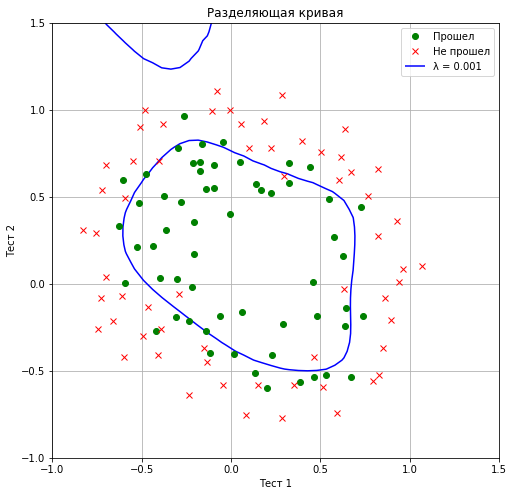

In [1411]:
plotBoundary(X2_new, Y2, 0.001)

**14. Попробуйте различные значения параметра регуляризации λ. Как выбор данного значения влияет на вид разделяющей кривой? Ответ дайте в виде графиков.**

<a list of 3 mcoll.LineCollection objects>


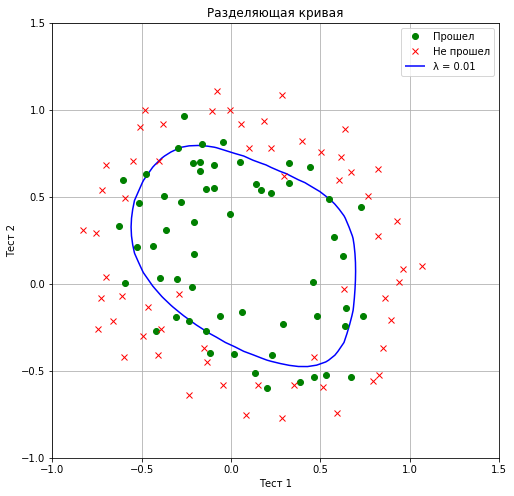

In [1412]:
plotBoundary(X2_new, Y2, 0.01)

<a list of 3 mcoll.LineCollection objects>


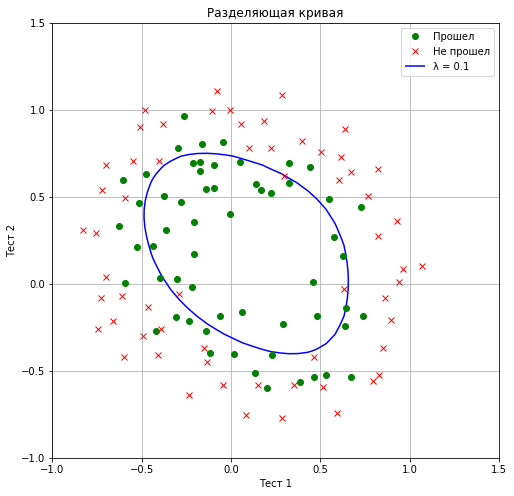

In [1166]:
plotBoundary(X2_new, Y2, 0.1)

<a list of 3 mcoll.LineCollection objects>


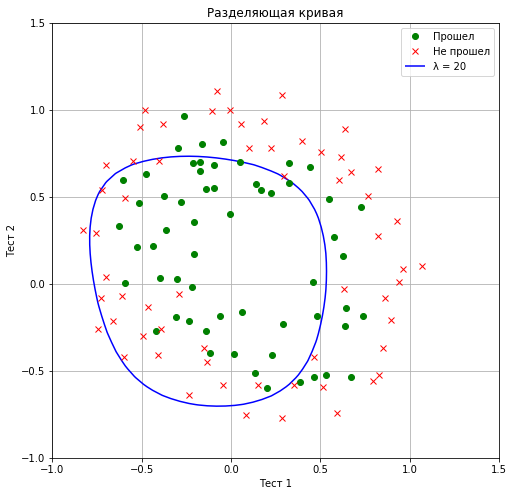

In [1168]:
plotBoundary(X2_new, Y2, 20)

**15. Загрузите данные ex2data3.mat из файла.**

Набор данных ex2data3.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).


In [1225]:
img_data = scipy.io.loadmat('ex2data3.mat')

In [1226]:
ex_3_X, ex_3_Y = img_data['X'], img_data['y']

In [1227]:
ex_3_X.shape

(5000, 400)

**16. Визуализируйте несколько случайных изображений из набора данных. Визуализация должна содержать каждую цифру как минимум один раз.**


In [1228]:
vals, indexes = np.unique(ex_3_Y, return_index=True)

In [1229]:
vals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [1230]:
def getImgFromRow(row):
    return row.reshape(20, 20).T

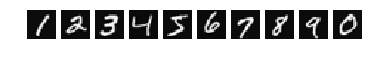

In [1232]:
fig, axs = plt.subplots(1, 10)

for i in range(len(indexes)):
    index = indexes[i]
    val = vals[i]
    axs[i].imshow(getImgFromRow(ex_3_X[index]), cmap='gray')
    axs[i].axis("off")
    
plt.show()

**17. Реализуйте бинарный классификатор с помощью логистической регрессии с использованием векторизации (функции потерь и градиентного спуска).**

**17. Добавьте L2-регуляризацию к модели.**


In [1233]:
ex_3_m = len(ex_3_Y)
ex_3_n = ex_3_X.shape[1]

In [1234]:
print(f'm = {ex_3_m}, n = {ex_3_n}')

m = 5000, n = 400


In [1235]:
ex_3_init_theta = np.zeros([ex_3_n, 1])
ex_3_init_theta.shape

(400, 1)

**19. Реализуйте многоклассовую классификацию по методу “один против всех”.**

In [1413]:
ex_3_X_ext = np.hstack((np.ones((ex_3_m, 1)), ex_3_X))

In [1488]:
def fmin_cg_alg(X, Y, lam=0):
    init_theta = np.zeros([X.shape[1], 1]).flatten()
    result = optimize.fmin_cg(J_reg, fprime=gd_step, x0=init_theta, args=(X, Y.flatten(), lam), maxiter=50, disp=False, full_output=True)
    return result[0], result[1]

In [1535]:
def train_classifier(X, Y, lam=0):
    m = X.shape[0]
    n = X.shape[1]
    
    classes_count = 10
    
    thetas = np.zeros([classes_count, n])
    
    for klass in range(classes_count):
        class_index = klass if klass else 10 # 10 - это 0
        print(f'{klass} => {class_index}')
        replaced_Y = (Y == class_index).astype(int)
        #theta, cost = fmin_cg_alg(X, replaced_Y, lam)  # lam - 0.001 -> 95.6%
        theta, cost = bfgs_cust_reg(X, replaced_Y, lam) # lam - 0.001 -> 97.2%
        thetas[klass] = theta
        
    return thetas
    
thetas = train_classifier(ex_3_X_ext, ex_3_Y, 0.001)
thetas.shape

0 => 10


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


1 => 1


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


2 => 2


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


3 => 3


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


4 => 4


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


5 => 5
6 => 6


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


7 => 7


/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/ls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


8 => 8
9 => 9


(10, 401)

**20. Реализуйте функцию предсказания класса по изображению с использованием обученных классификаторов.**

In [1491]:
def predClass(thetas, x):
    return np.argmax(h(thetas.T, x))

In [1497]:
i = 3000
x = ex_3_X_ext[i]
y = ex_3_Y[i].item()

print(f'Class = {y}, predicted = {predClass(thetas, x)}')

Class = 6, predicted = 6


**21. Процент правильных классификаций на обучающей выборке должен составлять около 95%.**

In [1534]:
def calc_accuracy(thetas, X, Y):
    m = X.shape[0]
    correct = 0
    
    for i in range(m):
        pred = predClass(thetas, X[i])
        pred = pred if pred else 10
        
        if pred == Y[i]:
            correct += 1

    return correct/m

print("Accuracy: %0.1f%%"%(100*calc_accuracy(thetas, ex_3_X_ext, ex_3_Y)))

Accuracy: 97.2%
